# Qiskit Notebook 8b - QAOA in a QPU


In this Notebook, we will learn about:

* Quantum Approximate Optimization Algorithm (QAOA) using an IBM QPU

In [ ]:
# If using Google Colab, uncomment the following

#!pip install -q qiskit=1.3.2
#!pip install -q qiskit[visualization]
#!pip install -q qiskit-ibm-runtime==0.34.0
#!pip install -q qiskit-aer==0.16.0
#!pip install -q rustworkx
#!pip install -q h5py

# Quantum Approximate Optimization Algorithm (QAOA)


The **Quantum Approximate Optimization Algorithm** (QAOA) corresponds to a variational quantum algorithm (inspired by quantum annealing) for solving combinatorial optimization methods on NISQ devices. QAOA uses an unitary operation $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$, characterized by the parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$, which prepares a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$, with the goal to maximize a cost function $F_p(\boldsymbol{\gamma},\boldsymbol{\beta})$ which represents the combinatorial problem.

The unitary operation $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ is made of two unitary operations:

* $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$, where $H_B$ corresponds to the *mixer* Hamiltonian.
* $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_C}$, where $H_C$ corresponds to the *cost* Hamiltonian, which encodes the solution to the optimization problem.

In general, $H_B$ is made up of sums of single qubit Pauli $X$ gates, given by

$$ H_B = \sum_{i = 1}^n X_i,$$

whereas $H_C$ corresponds to a Hamiltonian that is diagonal in the computational (Pauli $Z$) basis, and has at most $m$ local elements $\hat{C}_k$, 

$$ H_C = \sum_{k = 1}^m \hat{C}_k = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|, \quad x \in \{0,1\}^n .$$

The objective state (or QAOA ansatz in the description of VQA) is prepared by applying these unitary operations in alternating blocks $p$ times

$$
\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle = e^{ -i\beta_p H_B } e^{ -i\gamma_p H_C } \ldots e^{ -i\beta_1 H_B } e^{ -i\gamma_1 H_C } \lvert \psi_0 \rangle 
$$

where $\lvert \psi_0 \rangle$ is a convenient initial state corresponding to the ground state of the mixer Hamiltonian, which in this case corresponds to the uniform superposition of all computational basis states $|+\rangle^{\otimes n} = \bigg[\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg]^{\otimes n}$.

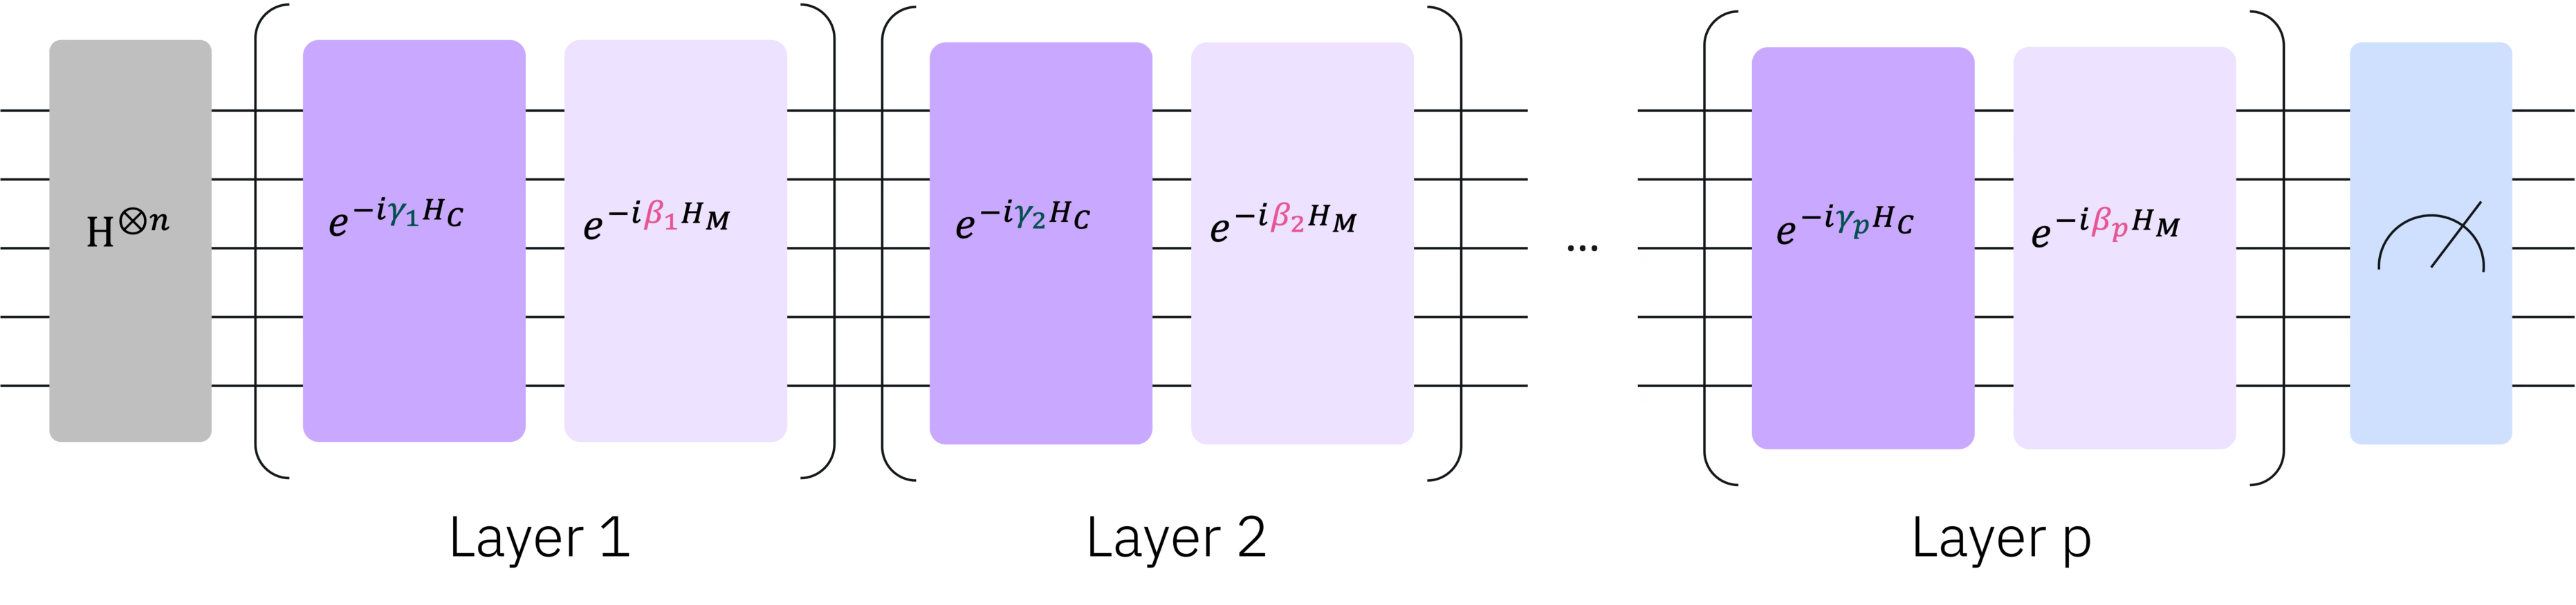

The objective of the algorithm is to find the optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ codifies the solution to the problem, which corresponds to maximizing the cost function


$$F_p(\boldsymbol{\gamma},\boldsymbol{\beta}) = \langle \psi_p(\boldsymbol{\gamma},\boldsymbol{\beta})|H_C|\psi_p(\boldsymbol{\gamma},\boldsymbol{\beta})\rangle= \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle |^2.
$$

As in the VQE case, the optimal $2p$ parameters are obtained through classical optimization methods.

## Max-Cut and Quadratic Unconstrained Binary Optimization (QUBO) problems

The **Max-Cut problem** is an NP-hard optimization problem with a number of different applications in clustering, network science, and statistical physics. For a given graph (as the one on the left), the goal is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized. Notice that this partition may not be unique!

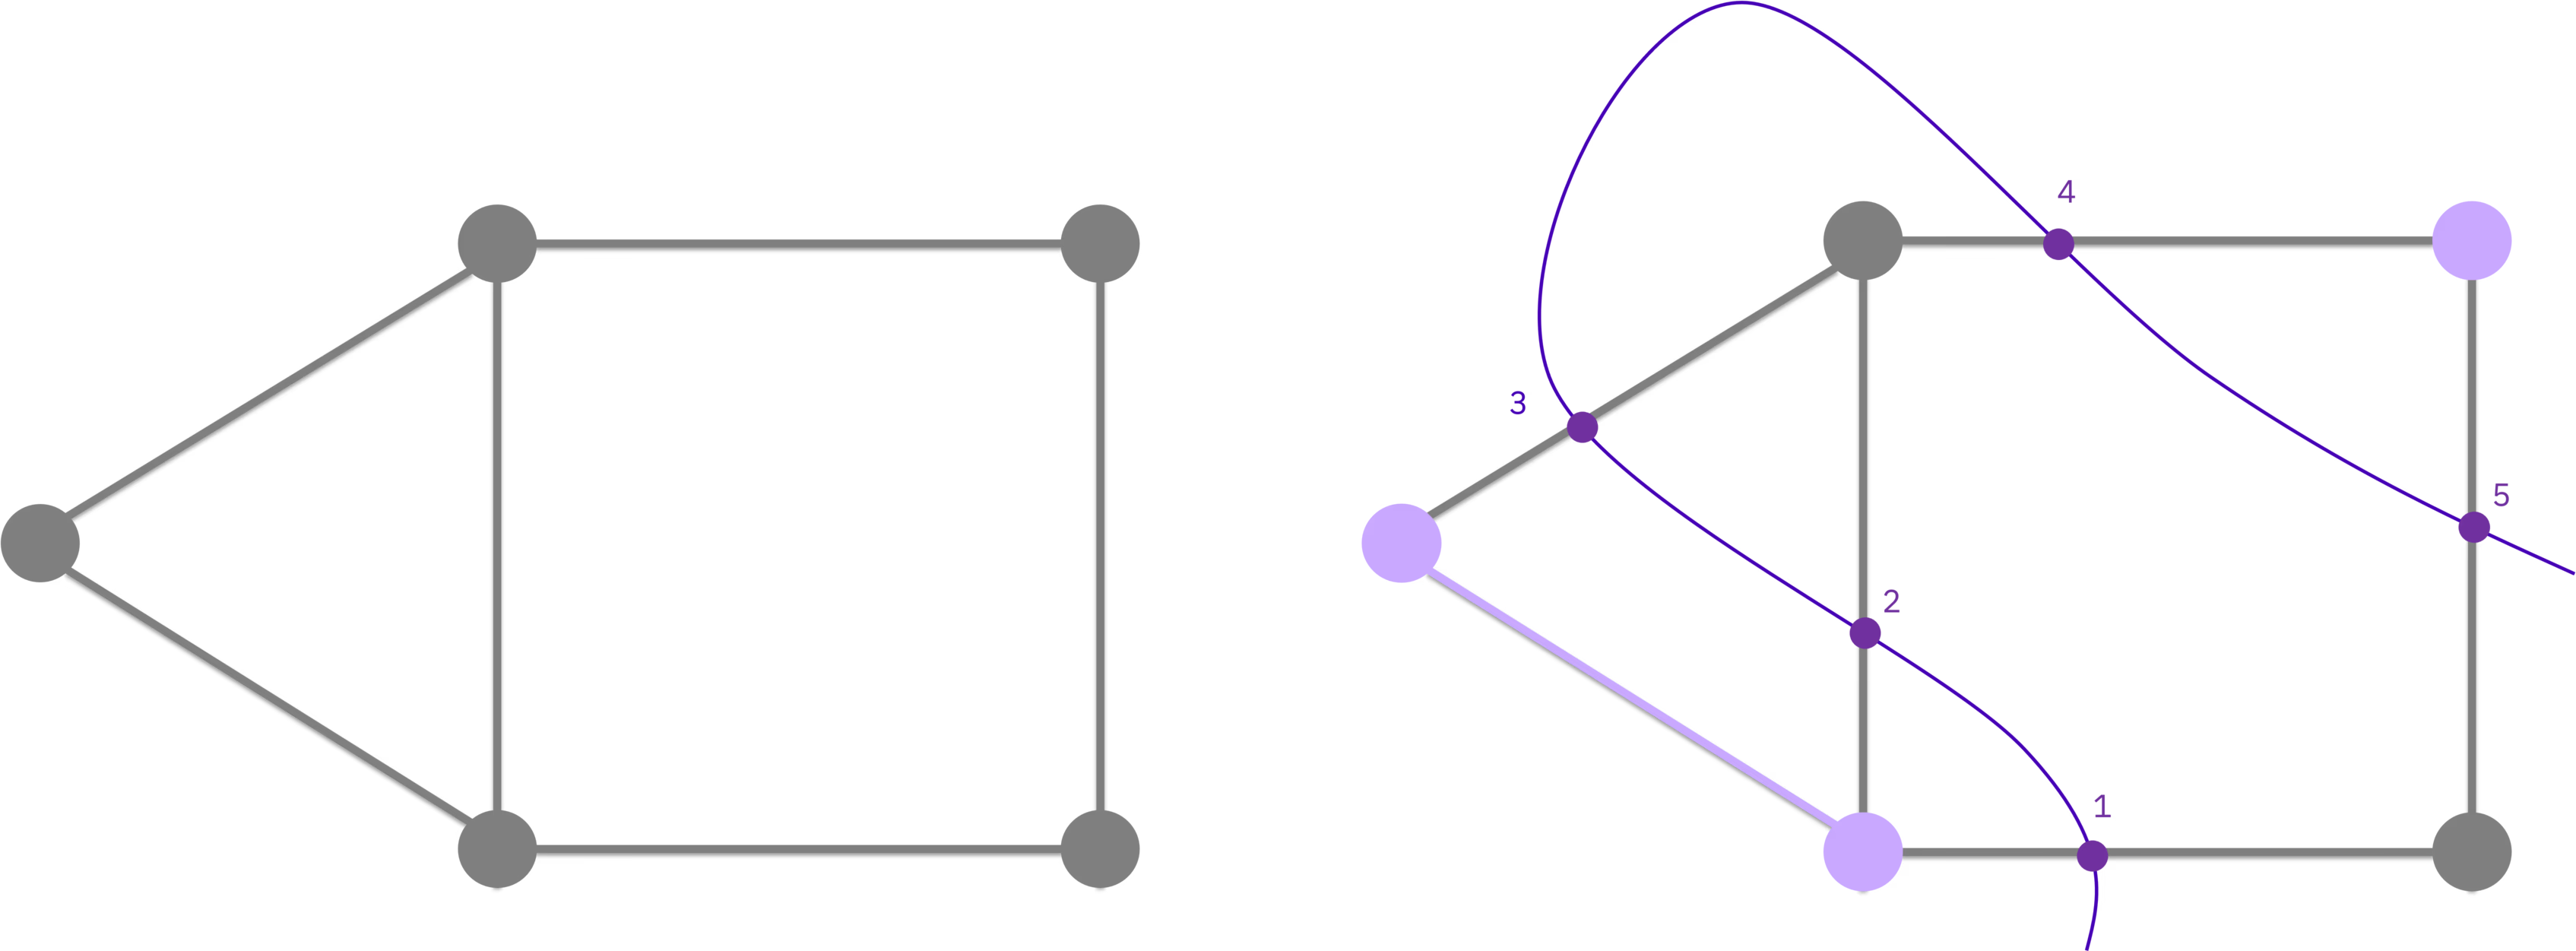

The Max-Cut problem can be mathematically represented as

$$
\max_{x \in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2x_i x_j,
$$

where $i$ and $j$ are the nodes of the graph, and $x_i$ and $x_j$ take as values $0$ or $1$ (i.e. are binary variables) depending on which side of the partition each node is on.

* If $x_i$ and $x_j$ are in the same side of the partition, the expression in the sum is zero.
* If $x_i$ and $x_j$ are in opposite sides, the expression is equal to one.

Then, maximizing the number of cuts will maximize the sum. We can equivalently write the problem as a minimization problem as

$$
\min_{x \in \{0,1\}^n} \sum_{(i,j)} 2x_i x_j - x_i - x_j
$$

More generally, this problem correspond to an example of a **Quadratic Unconstrained Binary Optimization** (QUBO) problem, which can be written in compact form as

$$
\min_{x \in \{0,1\}^n} x^T Qx
$$

where $Q$ is an $n \times n$ matrix of real numbers, and $n$ corresponds to the number of nodes in our graph. It can be shown that there exists a **one-to-one correspondence** between the $Q$ matrix of the QUBO problem and an Ising Hamiltonian, which will correspond for our purposes to the cost Hamiltonian used by QAOA:


$$
H_{C}=\sum_{i j} Q_{i j} Z_{i} Z_{j}+\sum_{i} b_{i} Z_{i}, \quad b_{i}=-\sum_{j} ( Q_{i j}+Q_{j i} ) . 
$$


The goal now will be to use QAOA to solve the Max-Cut problem for a $4$ node graph using a real QPU.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

#token = "<your-token>"

#QiskitRuntimeService.save_account(
#  token=token,
#  channel="ibm_quantum",
#  overwrite=True)

# Load saved credentials
service = QiskitRuntimeService()

backend = service.least_busy(operational=True)
print(backend)

In [ ]:
# Let us draw the graph, using the rustworkx library

import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# Number of nodes, which for the MaxCut problem also is the number of qubits
n = 4

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 2, 1.0), (0, 1, 1.0), (2, 3, 1.0), (3, 1, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to cost Hamiltonian.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

To construct the unitary operations required for the QAOA ansatz, we use the predefined `QAOAAnsatz` circuit.

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

# Lets consider two layers, which will correspond to four parameters
p = 2

qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
qaoa_circuit.measure_all()
print(qaoa_circuit.num_parameters)

qaoa_circuit.decompose(reps=0).draw('mpl')

Following what we learned from Qiskit Primitives, we need to transform the circuit into a ISA circuit and the cost Hamiltonian into an ISA observable.

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

pm_qaoa = generate_preset_pass_manager(backend=backend, optimization_level=3)


qaoa_circuit_trans = pm_qaoa.run(qaoa_circuit)
qaoa_circuit_trans.decompose(reps=0).draw('mpl', fold=-1, idle_wires=False)  # Draw only non-idle wires

In [ ]:
cost_hamiltonian_isa = cost_hamiltonian.apply_layout(layout=qaoa_circuit_trans.layout)
cost_hamiltonian_isa

Define the initial parameters for the hybrid optimization loop, and the cost function required for the classical optimization method.

In [ ]:
initial_gamma = 4                       # We will start from a good initial guess, to speed up the optimization
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    job = estimator.run(pubs=[pub])
    result = job.result()
    energy = result[0].data.evs[0]

    # The following lines are used to keep track of the cost function history

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"].append(params)
    cost_history_dict["cost_history"].append(energy)

    print(cost_history_dict["iters"])

    return energy

# Auxiliary dictionary to keep track of the cost function and parameters history

cost_history_dict = {
    "prev_vector": [],
    "iters": 0,
    "cost_history": [],
}

If you want to run the algorithm using your own QPU's resources from IBM Quantum, then uncomment the following lines. Otherwise, you can retrieve the (experimental) data obtained from the file `QAOA_DATA.h5`.

In [ ]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import EstimatorV2 as EstimatorRuntime

# estimator_qaoa = EstimatorRuntime(mode=backend)


# #Set simple error suppression/mitigation and shots for the Runtime Estimator

# estimator_qaoa.options.dynamical_decoupling.enable = True
# estimator_qaoa.options.dynamical_decoupling.sequence_type = "XY4"
# estimator_qaoa.options.twirling.enable_gates = True
# estimator_qaoa.options.twirling.num_randomizations = "auto"


# result_qpu = minimize(
#        cost_func,
#        init_params,
#        args=(qaoa_circuit_trans, cost_hamiltonian_isa, estimator_qaoa),
#        method="COBYLA",
#        tol=1e-2,
#        options={"maxiter": 40},
#    )

In [ ]:
# result_qpu

If you want to save your own data, uncomment the SAVE DATA lines. Otherwise, if you want to use the provided results, uncomment the LOAD DATA lines.

In [ ]:
import h5py
file_path = "QAOA_DATA.h5"

################# SAVE DATA ####################

# with h5py.File(file_path, "w") as f1:
#     f1.create_dataset("prev_vector", data=cost_history_dict["prev_vector"])
#     f1.create_dataset("cost_history", data=cost_history_dict["cost_history"])


################# LOAD DATA ####################

cost_history_dict = {}

with h5py.File(file_path, "r") as f1:
   cost_history_dict["prev_vector"] = f1["prev_vector"][:]
   cost_history_dict["cost_history"] = f1["cost_history"][:]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(cost_history_dict["cost_history"], label="Cost function")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.grid()
plt.legend()
plt.draw()

In [ ]:
min_arg_cost_function = np.argmin(cost_history_dict['cost_history'])

min_value_cost_function = cost_history_dict['cost_history'][min_arg_cost_function]
best_params = cost_history_dict['prev_vector'][min_arg_cost_function]

The algorithm looks for the optimal parameters, such that the cost function $F_p(\boldsymbol{\gamma},\boldsymbol{\beta})$ is minimized. Nonetheless, the solution to the optimization problem is encoded in the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$, so we have to measure it to get the required information that represents the optimal cut.

If you want to sample the circuit using your own QPU's resources from IBM Quantum, then uncomment the following lines. Otherwise, you can retrieve the (experimental) data obtained from the files `SAMPLER_DATA_BIN.h5` and `SAMPLER_DATA_INT.h5`.

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as SamplerRuntime

# Assign optimal parameters to the parametrized circuit

# optimized_circuit = qaoa_circuit_trans.assign_parameters(best_params)
# sampler_qaoa = SamplerRuntime(mode=backend)

# #We can also set error suppression/mitigation methods more specifically
# sampler_qaoa.options.default_shots = 10000
# sampler_qaoa.options.dynamical_decoupling.enable = True
# sampler_qaoa.options.dynamical_decoupling.sequence_type = "XY4"
# sampler_qaoa.options.twirling.enable_gates = True
# sampler_qaoa.options.twirling.num_randomizations = "auto"

# pub_sampler_qaoa = (optimized_circuit, )
# job_sampler_qaoa = sampler_qaoa.run([pub_sampler_qaoa], shots=int(1e4))

In [ ]:
# Auxiliary function to compute the final distribution of measurement results

def final_distribution(job):
    counts_int = job.result()[0].data.meas.get_int_counts()
    counts_bin = job.result()[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val/shots for key, val in counts_int.items()}
    final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

    return final_distribution_int, final_distribution_bin

In [ ]:
# final_distribution_int_qpu, final_distribution_bin_qpu = final_distribution(job_sampler_qaoa)
# print(final_distribution_int_qpu)

If you want to save your own data, uncomment the SAVE DATA lines. Otherwise, if you want to use the provided results, uncomment the LOAD DATA lines.

In [ ]:
file_path_bin = "SAMPLER_DATA_BIN.h5"
file_path_int = "SAMPLER_DATA_INT.h5"


################# SAVE DATA ####################

# with h5py.File(file_path_int, "w") as fint:
#     dict_group = fint.create_group('dict_data')
#     for k, v in final_distribution_int_qpu.items():
#         dict_group[f'{k}'] = v

# with h5py.File(file_path_bin, "w") as fbin:
#     dict_group = fbin.create_group('dict_data')
#     for k, v in final_distribution_bin_qpu.items():
#         dict_group[k] = v


# ################# LOAD DATA ####################


final_distribution_bin_qpu = {}

with h5py.File(file_path_bin, "r") as f2:

    dict_group_load = f2['dict_data']
    dict_group_keys = dict_group_load.keys()
    for k in dict_group_keys:
        final_distribution_bin_qpu[k]= dict_group_load[k][()]

final_distribution_int_qpu = {}

with h5py.File(file_path_int, "r") as f3:

    dict_group_load = f3['dict_data']
    dict_group_keys = dict_group_load.keys()
    for k in dict_group_keys:
        final_distribution_int_qpu[int(k)]= dict_group_load[k][()]

The post-processing steps ahead interpret the sampling output to return a solution for your original problem. In this case, we are interested in the **bitstring with the highest probability** as this determines the optimal cut. The symmetries in the problem allow for **two possible solutions**, and the sampling process should return one of them with a slightly higher probability.

In [ ]:
# auxiliary functions to sample most likely bitstring

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [ ]:
keys_qpu = list(final_distribution_int_qpu.keys())
values_qpu = list(final_distribution_int_qpu.values())
most_likely_qpu = keys_qpu[np.argmax(np.abs(values_qpu))]
most_likely_bitstring_qpu = to_bitstring(most_likely_qpu, len(graph))
most_likely_bitstring_qpu.reverse()

print("Result bitstring:", most_likely_bitstring_qpu)

In [ ]:
import matplotlib

matplotlib.rcParams.update({"font.size": 10})

final_bits_qpu = final_distribution_bin_qpu
values_qpu = np.abs(list(final_bits_qpu.values()))
top_2_values_qpu = sorted(values_qpu, reverse=True)[:2]
positions = []
for value in top_2_values_qpu:
    positions.append(np.where(values_qpu == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits_qpu.keys()), list(final_bits_qpu.values()), color="tab:blue")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:red")

In [ ]:
# auxiliary function to draw the graph and get tge value of the cut
def plot_result(G, x):
    colors = ["tab:blue" if i == 0 else "tab:red" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

In [ ]:
plot_result(graph, most_likely_bitstring_qpu)

In [ ]:
cut_value_qpu = evaluate_sample(most_likely_bitstring_qpu, graph)
print('The value of the cut is:', cut_value_qpu)